# 01 — Chaotic Systems & Delay Embedding

This notebook explores deterministic chaos and state-space reconstruction.

## Topics
- **Lorenz Attractor**: Classic 3D chaotic ODE (RK4 integration)
- **Delay Embedding (Takens)**: Reconstruct state-space from scalar observable
- **Strange Attractor Visualization**: Effect of embedding delay τ on geometry

---

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reproducibility
rng = np.random.default_rng(42)

## 1. Lorenz System Simulation (RK4)

The Lorenz system is a classic 3D chaotic ODE with parameters $\sigma=10$, $\rho=28$, $\beta=8/3$:

$$
\frac{dx}{dt} = \sigma(y - x), \quad
\frac{dy}{dt} = x(\rho - z) - y, \quad
\frac{dz}{dt} = xy - \beta z
$$

Integrated using 4th-order Runge-Kutta (RK4).

**Sources**: [DeepLagAttention.ipynb](../../DeepLagAttention.ipynb), [NeuralOperator.ipynb](../../NeuralOperator.ipynb), [TimeVariying_AR_Simualtion.ipynb](../../TimeVariying_AR_Simualtion.ipynb)

In [2]:
# -----------------------------------------------------------------------------
# Lorenz System Simulation via RK4
# Source: DeepLagAttention.ipynb, NeuralOperator.ipynb, TimeVariying_AR_Simualtion.ipynb
# -----------------------------------------------------------------------------

def lorenz(T_steps=30000, dt=0.005, sigma=10.0, rho=28.0, beta=8/3, x0=(1.0, 1.0, 1.0)):
    """
    Simulate the Lorenz system using 4th-order Runge-Kutta (RK4).
    
    Parameters
    ----------
    T_steps : int
        Number of time steps to simulate.
    dt : float
        Time step size.
    sigma, rho, beta : float
        Lorenz system parameters (classic values: 10, 28, 8/3).
    x0 : tuple
        Initial conditions (x, y, z).
    
    Returns
    -------
    xs, ys, zs : np.ndarray
        State trajectories of shape (T_steps,).
    """
    x, y, z = x0
    xs, ys, zs = [], [], []
    
    for _ in range(T_steps):
        # Lorenz derivatives
        def f(x, y, z):
            dx = sigma * (y - x)
            dy = x * (rho - z) - y
            dz = x * y - beta * z
            return dx, dy, dz
        
        # RK4 stages
        k1 = f(x, y, z)
        k2 = f(x + 0.5*dt*k1[0], y + 0.5*dt*k1[1], z + 0.5*dt*k1[2])
        k3 = f(x + 0.5*dt*k2[0], y + 0.5*dt*k2[1], z + 0.5*dt*k2[2])
        k4 = f(x + dt*k3[0], y + dt*k3[1], z + dt*k3[2])
        
        # Update state
        x += (dt/6.0) * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        y += (dt/6.0) * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        z += (dt/6.0) * (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        
        xs.append(x)
        ys.append(y)
        zs.append(z)
    
    return np.array(xs), np.array(ys), np.array(zs)


# Generate Lorenz trajectory
dt = 0.005
xs, ys, zs = lorenz(T_steps=20000, dt=dt)
t = np.arange(len(xs)) * dt

print(f"Lorenz trajectory: {len(xs)} samples, dt={dt}s, total time={t[-1]:.1f}s")

Lorenz trajectory: 20000 samples, dt=0.005s, total time=100.0s


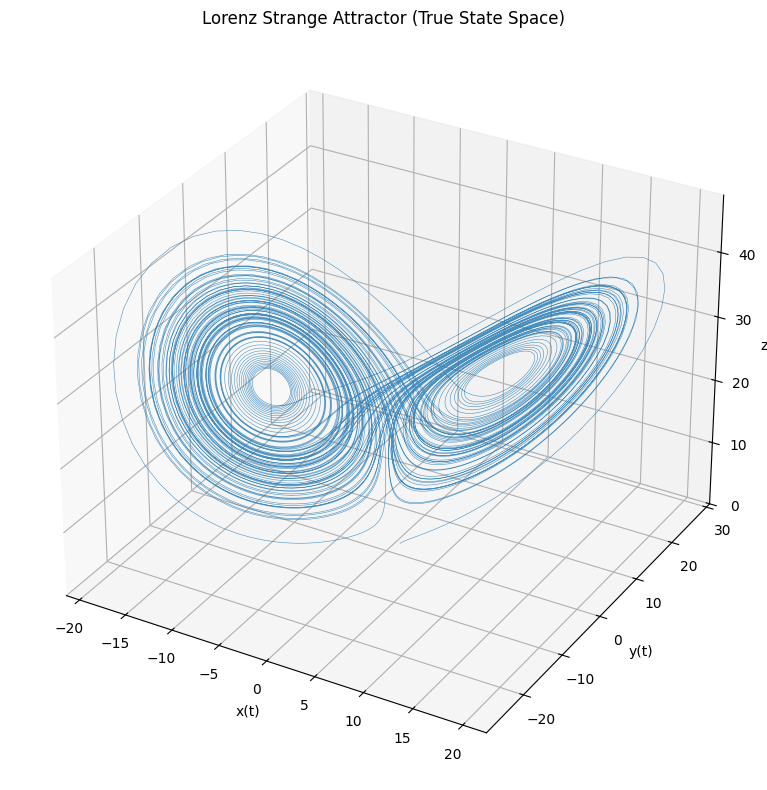

In [3]:
# -----------------------------------------------------------------------------
# Visualize Lorenz attractor in 3D (true state space)
# Source: TimeVariying_AR_Simualtion.ipynb
# -----------------------------------------------------------------------------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[::2], ys[::2], zs[::2], linewidth=0.4, alpha=0.8)
ax.set_xlabel('x(t)')
ax.set_ylabel('y(t)')
ax.set_zlabel('z(t)')
ax.set_title('Lorenz Strange Attractor (True State Space)')
plt.tight_layout()
plt.show()

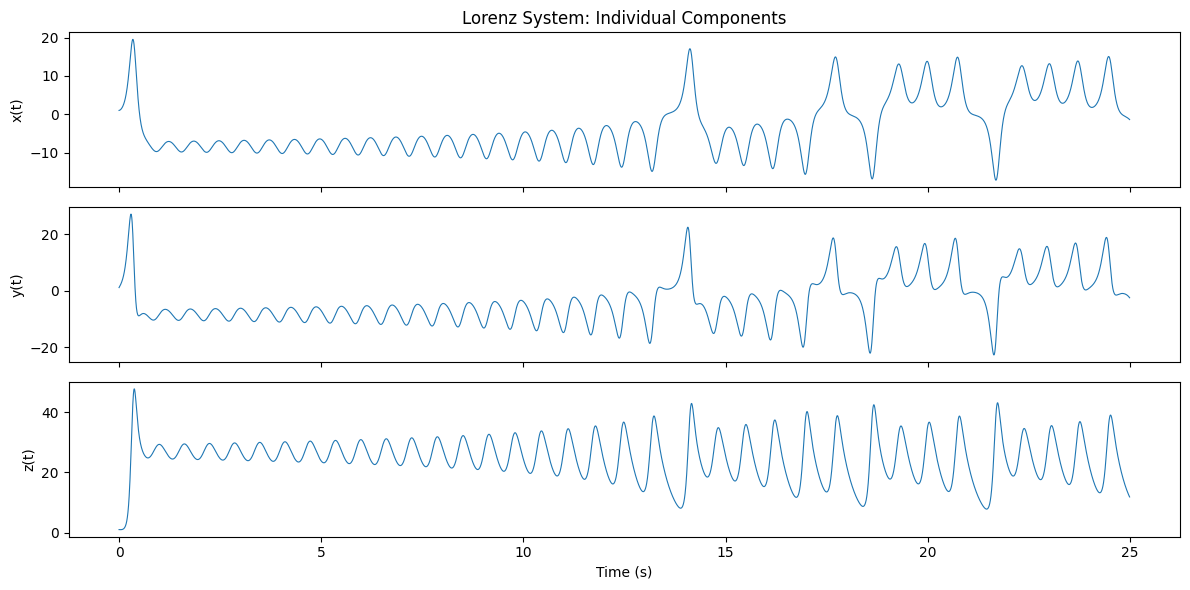

In [4]:
# -----------------------------------------------------------------------------
# Time series of Lorenz x(t) — the observable we'll use for embedding
# Source: TimeVariying_AR_Simualtion.ipynb
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

axes[0].plot(t[:5000], xs[:5000], linewidth=0.8)
axes[0].set_ylabel('x(t)')
axes[0].set_title('Lorenz System: Individual Components')

axes[1].plot(t[:5000], ys[:5000], linewidth=0.8)
axes[1].set_ylabel('y(t)')

axes[2].plot(t[:5000], zs[:5000], linewidth=0.8)
axes[2].set_ylabel('z(t)')
axes[2].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

---

## 2. Delay Embedding (Takens' Theorem)

**Takens' Theorem** states that a scalar time series $x(t)$ from a dynamical system can be used to reconstruct the underlying state space via **delay embedding**:

$$
\mathbf{y}_t = [x_t, x_{t-\tau}, x_{t-2\tau}, \ldots, x_{t-(m-1)\tau}]
$$

where:
- $m$ = embedding dimension
- $\tau$ = delay (in samples)

**Sources**: [1overf_sim.ipynb](../../1overf_sim.ipynb), [TimeVariying_AR_Simualtion.ipynb](../../TimeVariying_AR_Simualtion.ipynb), [DeepLagAttention.ipynb](../../DeepLagAttention.ipynb)

In [5]:
# -----------------------------------------------------------------------------
# Delay Embedding Functions — Multiple Variants from the Repo
# -----------------------------------------------------------------------------

# Variant 1: General m-dimensional embedding
# Source: 1overf_sim.ipynb
def lag_embed(x, tau, m):
    """
    Construct delay-embedded matrix from scalar time series.
    
    Parameters
    ----------
    x : np.ndarray
        1D time series of length N.
    tau : int
        Delay in samples.
    m : int
        Embedding dimension.
    
    Returns
    -------
    Y : np.ndarray
        Embedded matrix of shape (N - (m-1)*tau, m).
    """
    T = len(x) - (m - 1) * tau
    return np.column_stack([x[i*tau : i*tau + T] for i in range(m)])


# Variant 2: Specific 3D embedding helper
# Source: DeepLagAttention.ipynb
def embed3(s, tau):
    """
    Embed scalar signal into 3D: [s(t), s(t-τ), s(t-2τ)].
    
    Parameters
    ----------
    s : np.ndarray
        1D time series.
    tau : int
        Delay in samples.
    
    Returns
    -------
    np.ndarray
        Embedded array of shape (N - 2*tau, 3).
    """
    return np.column_stack([s[2*tau:], s[tau:-tau], s[:-2*tau]])


# Variant 3: With bounds checking
# Source: TimeVariying_AR_Simualtion.ipynb
def delay_embed(x, m, tau):
    """
    Delay embedding with bounds checking.
    
    Parameters
    ----------
    x : np.ndarray
        1D time series.
    m : int
        Embedding dimension.
    tau : int
        Delay in samples.
    
    Returns
    -------
    np.ndarray
        Embedded matrix of shape (N - (m-1)*tau, m).
    
    Raises
    ------
    ValueError
        If embedding parameters are too large for signal length.
    """
    N = len(x)
    n_rows = N - (m - 1) * tau
    if n_rows <= 0:
        raise ValueError("Embedding too large for signal length; reduce m or tau.")
    
    return np.column_stack([x[i*tau : i*tau + n_rows] for i in range(m)])


print("Delay embedding functions defined: lag_embed(), embed3(), delay_embed()")

Delay embedding functions defined: lag_embed(), embed3(), delay_embed()


---

## 3. Reconstructing the Lorenz Attractor from x(t) Only

Using **only** the scalar x(t) component, we can reconstruct the strange attractor geometry via delay embedding. The choice of $\tau$ significantly affects the quality of reconstruction.

**Source**: [TimeVariying_AR_Simualtion.ipynb](../../TimeVariying_AR_Simualtion.ipynb)

Original signal: 20000 samples
Embedded manifold: 19970 points in 3D
τ = 15 samples ≈ 0.075s


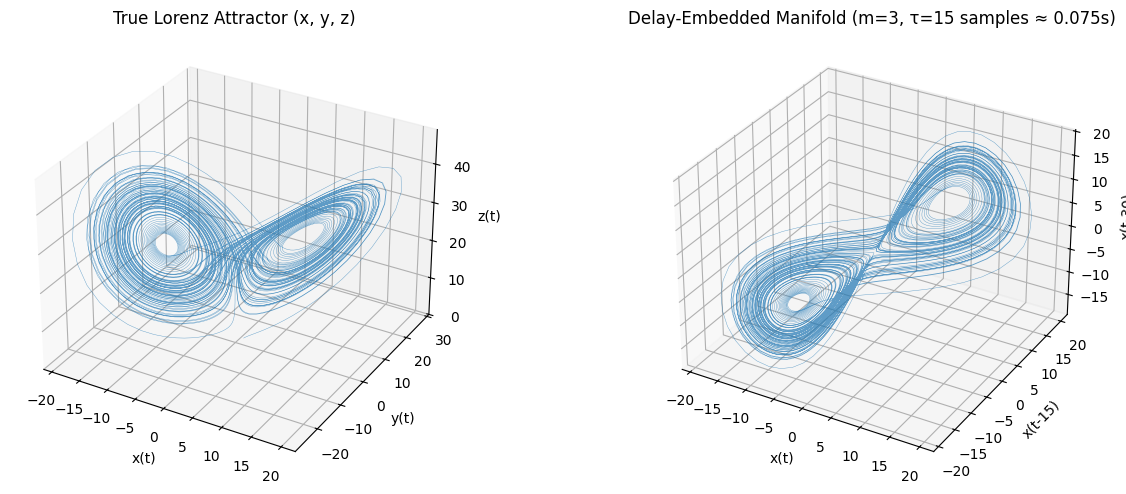

In [6]:
# -----------------------------------------------------------------------------
# 3D Delay Embedding of Lorenz x(t) — Single τ
# Source: TimeVariying_AR_Simualtion.ipynb
# -----------------------------------------------------------------------------

# Embedding parameters
m_embed = 3      # 3D embedding
tau = 15         # delay in samples (~0.075s with dt=0.005)
fs = 1.0 / dt    # sampling frequency

# Construct embedding from x(t) only
Xemb = delay_embed(xs, m_embed, tau)

print(f"Original signal: {len(xs)} samples")
print(f"Embedded manifold: {Xemb.shape[0]} points in {Xemb.shape[1]}D")
print(f"τ = {tau} samples ≈ {tau/fs:.3f}s")

# Compare true attractor vs reconstructed
fig = plt.figure(figsize=(14, 5))

# True 3D state space
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs[::3], ys[::3], zs[::3], linewidth=0.3, alpha=0.7)
ax1.set_xlabel('x(t)')
ax1.set_ylabel('y(t)')
ax1.set_zlabel('z(t)')
ax1.set_title('True Lorenz Attractor (x, y, z)')

# Reconstructed from x(t) via delay embedding
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(Xemb[::3, 0], Xemb[::3, 1], Xemb[::3, 2], linewidth=0.3, alpha=0.7)
ax2.set_xlabel('x(t)')
ax2.set_ylabel(f'x(t-{tau})')
ax2.set_zlabel(f'x(t-{2*tau})')
ax2.set_title(f'Delay-Embedded Manifold (m={m_embed}, τ={tau} samples ≈ {tau/fs:.3f}s)')

plt.tight_layout()
plt.show()

---

## 4. Effect of Delay τ on Attractor Geometry

The choice of embedding delay $\tau$ critically affects the reconstructed attractor:
- **Too small τ**: Points cluster near the diagonal (redundant information)
- **Too large τ**: Structure becomes distorted (decorrelated information)
- **Optimal τ**: Typically around the first zero-crossing or first minimum of the autocorrelation function

**Source**: [TimeVariying_AR_Simualtion.ipynb](../../TimeVariying_AR_Simualtion.ipynb), [1overf_sim.ipynb](../../1overf_sim.ipynb)

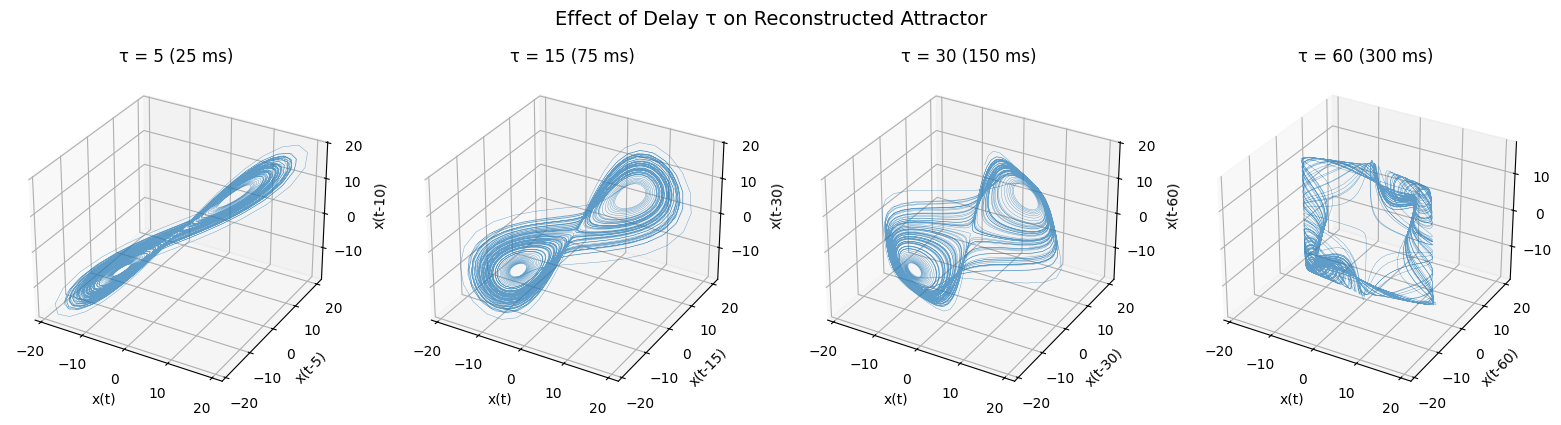

In [7]:
# -----------------------------------------------------------------------------
# Exploring Different τ Values
# Source: TimeVariying_AR_Simualtion.ipynb, 1overf_sim.ipynb
# -----------------------------------------------------------------------------

# Different embedding delays to compare
taus_to_compare = [5, 15, 30, 60]

fig = plt.figure(figsize=(16, 4))

for i, tauj in enumerate(taus_to_compare):
    Xe = delay_embed(xs, 3, tauj)
    
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.plot(Xe[::5, 0], Xe[::5, 1], Xe[::5, 2], linewidth=0.3, alpha=0.7)
    ax.set_xlabel('x(t)')
    ax.set_ylabel(f'x(t-{tauj})')
    ax.set_zlabel(f'x(t-{2*tauj})')
    ax.set_title(f'τ = {tauj} ({tauj*dt*1000:.0f} ms)')

plt.suptitle('Effect of Delay τ on Reconstructed Attractor', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

---

## 5. Autocorrelation for τ Selection

A common heuristic: choose $\tau$ at the first minimum or first zero-crossing of the autocorrelation function. This balances independence between delay coordinates.

**Source**: [1overf_sim.ipynb](../../1overf_sim.ipynb), [DeepLagAttention.ipynb](../../DeepLagAttention.ipynb)

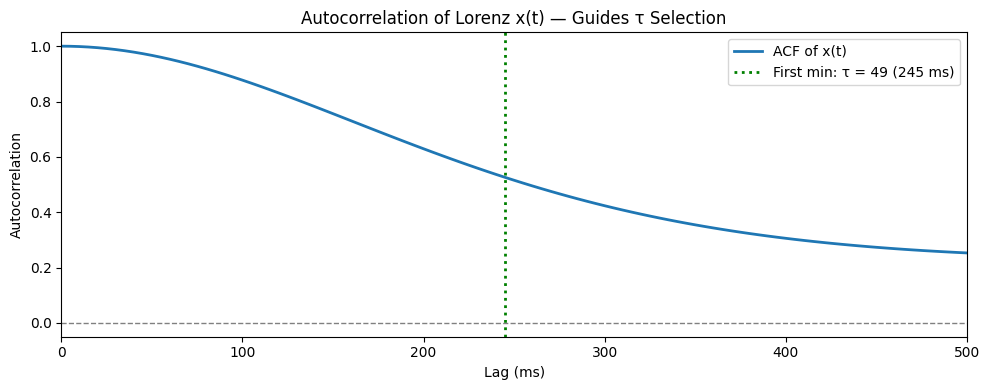

No zero-crossing found in the computed ACF range.
Suggested τ from first minimum: 49 samples (245 ms)


In [13]:
# -----------------------------------------------------------------------------
# Autocorrelation Function for τ Selection
# Source: 1overf_sim.ipynb, DeepLagAttention.ipynb
# -----------------------------------------------------------------------------

def autocorr(x, max_lag):
    """
    Compute normalized autocorrelation function.
    
    Parameters
    ----------
    x : np.ndarray
        1D time series.
    max_lag : int
        Maximum lag to compute.
    
    Returns
    -------
    np.ndarray
        Autocorrelation values from lag 0 to max_lag.
    """
    s = x - np.mean(x)
    ac = np.correlate(s, s, mode="full")
    ac = ac[ac.size // 2:]
    ac0 = ac[0] if ac[0] != 0 else 1.0
    return (ac / ac0)[:max_lag + 1]


# Compute ACF of Lorenz x(t)
max_lag = 100
acf_xs = autocorr(xs, max_lag)
lags = np.arange(max_lag + 1)

# Find first zero crossing
zero_crossings = np.where(np.diff(np.sign(acf_xs)))[0]
first_zero = zero_crossings[0] if len(zero_crossings) > 0 else None

# Find first minimum
first_min_idx = np.argmin(acf_xs[:50]) if len(acf_xs) > 50 else np.argmin(acf_xs)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(lags * dt * 1000, acf_xs, linewidth=2, label='ACF of x(t)')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

if first_zero is not None:
    ax.axvline(first_zero * dt * 1000, color='red', linestyle=':', linewidth=2, 
               label=f'First zero: τ = {first_zero} ({first_zero*dt*1000:.0f} ms)')
    
ax.axvline(first_min_idx * dt * 1000, color='green', linestyle=':', linewidth=2,
           label=f'First min: τ = {first_min_idx} ({first_min_idx*dt*1000:.0f} ms)')

ax.set_xlabel('Lag (ms)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of Lorenz x(t) — Guides τ Selection')
ax.legend()
ax.set_xlim([0, max_lag * dt * 1000])
plt.tight_layout()
plt.show()

if first_zero is not None:
    print(f"Suggested τ from first zero-crossing: {first_zero} samples ({first_zero*dt*1000:.0f} ms)")
else:
    print("No zero-crossing found in the computed ACF range.")
print(f"Suggested τ from first minimum: {first_min_idx} samples ({first_min_idx*dt*1000:.0f} ms)")

---

## 6. 2D Delay Embeddings — Different Signals

Comparing delay embeddings for different types of signals reveals their dynamical structure.

**Source**: [1overf_sim.ipynb](../../1overf_sim.ipynb)

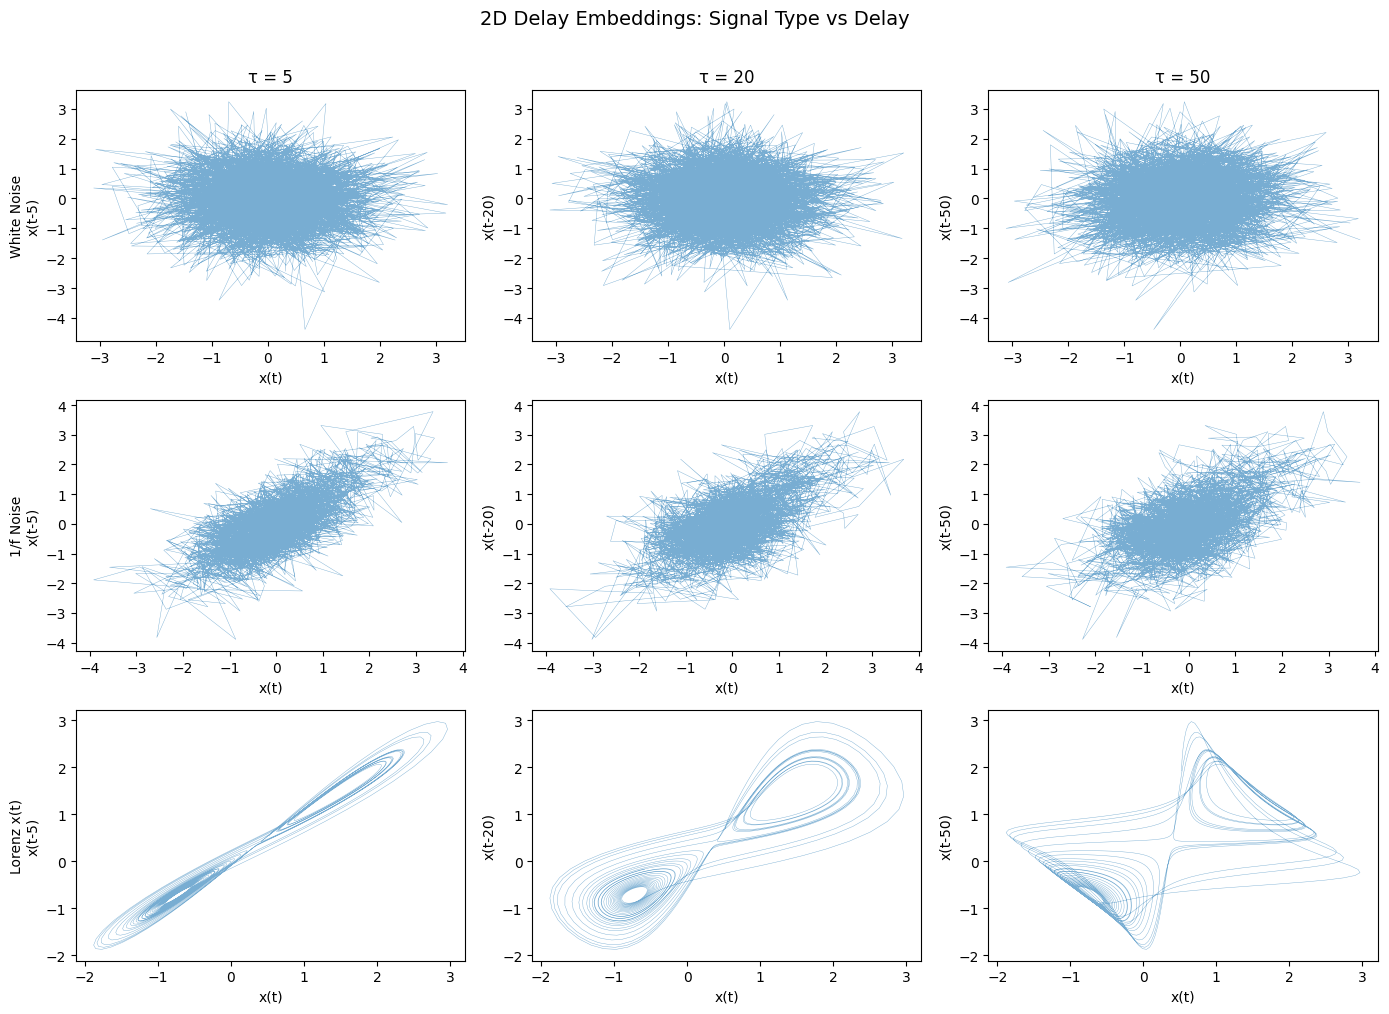

In [9]:
# -----------------------------------------------------------------------------
# 2D Delay Embeddings: White Noise vs 1/f Noise vs Lorenz
# Source: 1overf_sim.ipynb
# -----------------------------------------------------------------------------

def make_white_noise(n, seed=0):
    """Generate white (Gaussian) noise."""
    rng = np.random.default_rng(seed)
    return rng.standard_normal(n)


def make_1_over_f_noise(n, fs=1.0, alpha=1.0, seed=0):
    """
    Generate 1/f^α (pink) noise via spectral shaping.
    
    Parameters
    ----------
    n : int
        Number of samples.
    fs : float
        Sampling frequency.
    alpha : float
        Spectral exponent (α=1 → pink noise).
    seed : int
        Random seed.
    
    Returns
    -------
    np.ndarray
        Normalized 1/f noise.
    """
    rng = np.random.default_rng(seed)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    X = rng.standard_normal(freqs.shape) + 1j * rng.standard_normal(freqs.shape)
    mag = np.ones_like(freqs)
    mag[1:] = 1.0 / (freqs[1:] ** (alpha / 2))
    mag[0] = 0.0
    x = np.fft.irfft(X * mag, n=n)
    return (x - np.mean(x)) / np.std(x)


# Generate signals
n_sig = 6000
x_white = make_white_noise(n_sig, seed=42)
x_pink = make_1_over_f_noise(n_sig, fs=200, alpha=1.0, seed=42)
x_lorenz = xs[:n_sig]
x_lorenz = (x_lorenz - np.mean(x_lorenz)) / np.std(x_lorenz)  # normalize

# 2D embeddings at different τ
taus_2d = [5, 20, 50]

fig, axes = plt.subplots(3, len(taus_2d), figsize=(14, 10))
signals = [('White Noise', x_white), ('1/f Noise', x_pink), ('Lorenz x(t)', x_lorenz)]

for row, (name, sig) in enumerate(signals):
    for col, tau in enumerate(taus_2d):
        Y = lag_embed(sig, tau, 2)[::3]  # subsample for clarity
        ax = axes[row, col]
        ax.plot(Y[:, 0], Y[:, 1], linewidth=0.3, alpha=0.6)
        ax.set_xlabel('x(t)')
        ax.set_ylabel(f'x(t-{tau})')
        if row == 0:
            ax.set_title(f'τ = {tau}')
        if col == 0:
            ax.set_ylabel(f'{name}\nx(t-{tau})')

plt.suptitle('2D Delay Embeddings: Signal Type vs Delay', y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

---

## 7. 3D Embeddings Comparison

3D delay embeddings reveal the full attractor structure. White noise fills the space uniformly, 1/f noise shows correlated structure, and chaotic signals show fractal geometry.

**Source**: [1overf_sim.ipynb](../../1overf_sim.ipynb)

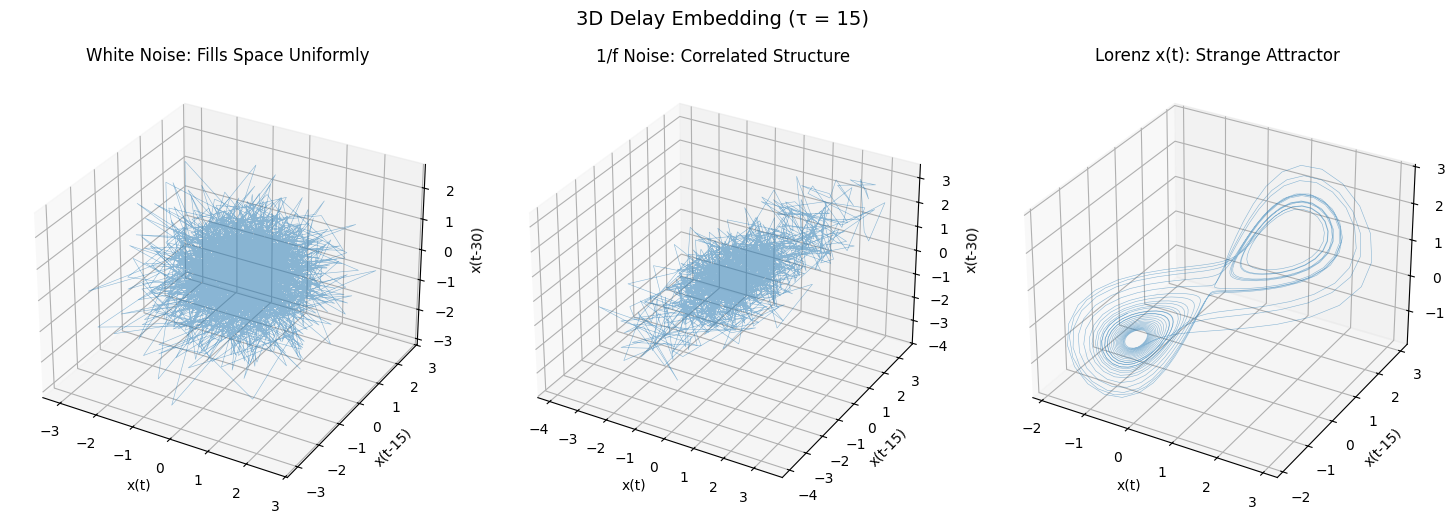

In [10]:
# -----------------------------------------------------------------------------
# 3D Delay Embeddings: White Noise vs 1/f Noise vs Lorenz
# Source: 1overf_sim.ipynb
# -----------------------------------------------------------------------------

tau_3d = 15

# Compute 3D embeddings
Yw3 = lag_embed(x_white, tau_3d, 3)[::5]
Yp3 = lag_embed(x_pink, tau_3d, 3)[::5]
Yl3 = lag_embed(x_lorenz, tau_3d, 3)[::5]

fig = plt.figure(figsize=(15, 5))

# White noise
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot(Yw3[:, 0], Yw3[:, 1], Yw3[:, 2], linewidth=0.4, alpha=0.5)
ax1.set_xlabel('x(t)')
ax1.set_ylabel(f'x(t-{tau_3d})')
ax1.set_zlabel(f'x(t-{2*tau_3d})')
ax1.set_title('White Noise: Fills Space Uniformly')

# 1/f noise
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot(Yp3[:, 0], Yp3[:, 1], Yp3[:, 2], linewidth=0.4, alpha=0.5)
ax2.set_xlabel('x(t)')
ax2.set_ylabel(f'x(t-{tau_3d})')
ax2.set_zlabel(f'x(t-{2*tau_3d})')
ax2.set_title('1/f Noise: Correlated Structure')

# Lorenz
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot(Yl3[:, 0], Yl3[:, 1], Yl3[:, 2], linewidth=0.4, alpha=0.5)
ax3.set_xlabel('x(t)')
ax3.set_ylabel(f'x(t-{tau_3d})')
ax3.set_zlabel(f'x(t-{2*tau_3d})')
ax3.set_title('Lorenz x(t): Strange Attractor')

plt.suptitle(f'3D Delay Embedding (τ = {tau_3d})', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

---

## 8. Lag Matrix for AR Modeling

For autoregressive modeling, we construct a lag matrix where each row contains past values of the signal. This is the foundation for fitting AR/NAR models to chaotic data.

**Source**: [TimeVariying_AR_Simualtion.ipynb](../../TimeVariying_AR_Simualtion.ipynb)

AR(20) model fitted to Lorenz x(t)
  Residual variance σ² = 0.0000
  AIC = -766756.91, BIC = -766590.96


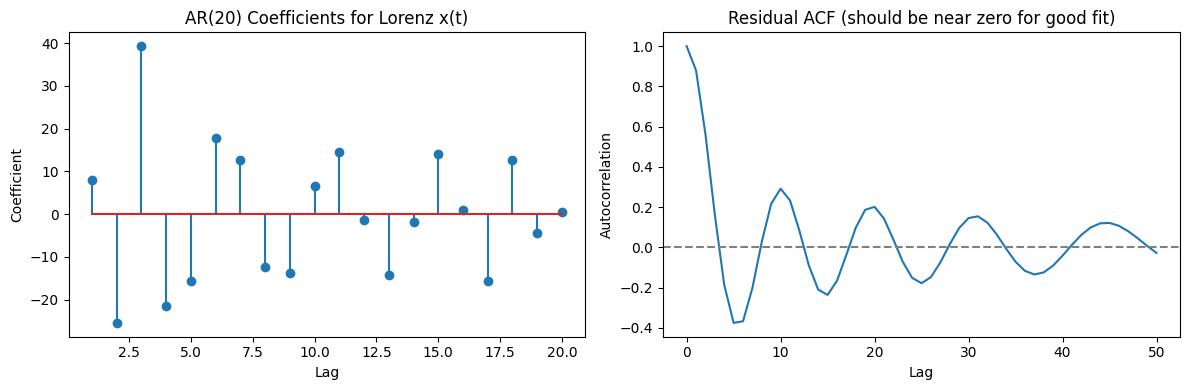

In [11]:
# -----------------------------------------------------------------------------
# Lag Matrix Construction for AR Modeling
# Source: TimeVariying_AR_Simualtion.ipynb
# -----------------------------------------------------------------------------

def lag_matrix(x, p, include_intercept=True):
    """
    Construct lag matrix for AR(p) regression.
    
    Parameters
    ----------
    x : np.ndarray
        1D time series of length N.
    p : int
        AR order (number of lags).
    include_intercept : bool
        Whether to include a column of ones.
    
    Returns
    -------
    X : np.ndarray
        Design matrix of shape (N-p, p+1) or (N-p, p).
    y : np.ndarray
        Target vector of shape (N-p,).
    """
    N = len(x)
    n_eff = N - p
    y = x[p:].copy()
    
    if include_intercept:
        X = np.zeros((n_eff, p + 1))
        X[:, 0] = 1.0
        for i in range(p):
            X[:, i+1] = x[p-1-i : N-1-i]
    else:
        X = np.zeros((n_eff, p))
        for i in range(p):
            X[:, i] = x[p-1-i : N-1-i]
    
    return X, y


def fit_ar_ols(x, p, include_intercept=True):
    """
    Fit AR(p) model via ordinary least squares.
    
    Returns
    -------
    coef : np.ndarray
        AR coefficients (intercept + lags if include_intercept).
    resid : np.ndarray
        Residuals.
    sigma2, AIC, BIC : float
        Variance and information criteria.
    y, yhat : np.ndarray
        True and predicted values.
    """
    X, y = lag_matrix(x, p, include_intercept=include_intercept)
    coef, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ coef
    resid = y - yhat
    n = len(y)
    k = len(coef)
    sigma2 = (resid @ resid) / n
    AIC = 2*k + n * np.log(sigma2)
    BIC = k * np.log(n) + n * np.log(sigma2)
    return coef, resid, sigma2, AIC, BIC, y, yhat


# Example: fit AR(20) to Lorenz x(t)
p_order = 20
coef, resid, sigma2, AIC, BIC, y_true, y_pred = fit_ar_ols(xs, p_order)

print(f"AR({p_order}) model fitted to Lorenz x(t)")
print(f"  Residual variance σ² = {sigma2:.4f}")
print(f"  AIC = {AIC:.2f}, BIC = {BIC:.2f}")

# Visualize coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].stem(np.arange(1, p_order+1), coef[1:])
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Coefficient')
axes[0].set_title(f'AR({p_order}) Coefficients for Lorenz x(t)')

# Residual ACF
resid_acf = autocorr(resid, 50)
axes[1].plot(resid_acf)
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')
axes[1].set_title('Residual ACF (should be near zero for good fit)')

plt.tight_layout()
plt.show()

---

## 9. Summary

This notebook consolidated chaotic systems and delay embedding code from across the repository:

| Concept | Functions | Sources |
|---------|-----------|---------|
| **Lorenz RK4** | `lorenz()` | DeepLagAttention, NeuralOperator, TimeVariying_AR_Simualtion |
| **Delay Embedding** | `lag_embed()`, `embed3()`, `delay_embed()` | 1overf_sim, DeepLagAttention, TimeVariying_AR_Simualtion |
| **Autocorrelation** | `autocorr()` | 1overf_sim, DeepLagAttention |
| **Noise Generation** | `make_white_noise()`, `make_1_over_f_noise()` | 1overf_sim |
| **AR Modeling** | `lag_matrix()`, `fit_ar_ols()` | TimeVariying_AR_Simualtion |

### Key Insights:
1. **Takens' Theorem** allows state-space reconstruction from scalar observables
2. **τ selection** via ACF first-minimum/zero-crossing heuristic
3. **Different signals** produce characteristic embedding geometries
4. **Linear AR** is a first approximation; nonlinear extensions needed for chaos